In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import simpson

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
c = 3 * 1e8  # Speed of light in m/s
eps0 = 8.85 * 1e-12
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)

In [4]:
# Parametersd
n_sub = 1.5 # Refractive index outside
n_core = 3.5  # Core refractive index
n_clad = 1.5 # Cladding refractive index
d = 0.2e-6  # Thickness in meters
d_coup = 0.6e-6 # Distance between waveguides
wavelength = 1.55e-6  # Wavelength in meters

In [5]:
k0 = 2 * np.pi / wavelength  # Free space wave number
omega = 2 * np.pi * c / wavelength  # Angular frequency

V = k0 * d * np.sqrt(n_core ** 2 - n_clad ** 2)  # Normalized frequency for given parameters
print(f"V = {round(V, 3)}")

V = 2.564


In [6]:
max_modes = int(np.floor(V / np.pi)) + 1  # Number of modes (N=0, 1, 2)
print(f"Number of modes: {max_modes}")
b_te = []
b_tm = []

Number of modes: 1


In [7]:
# Characteristic equations for TE modes
def characteristic_TE(b, V, n_core, n_clad, n_sub, N):
    a = (n_clad ** 2 - n_sub ** 2) / (n_core ** 2 - n_clad ** 2)
    lhs = np.arctan(np.sqrt(max(b, 0) / max(1 - b, 1e-9))) + np.arctan(np.sqrt(max(b + a, 0) / max(1 - b, 1e-9)))
    rhs = V * np.sqrt(max(1 - b, 0)) - np.pi * N
    return lhs - rhs

In [8]:
# Corrected characteristic equation for TM modes
def characteristic_TM(b, V, n_core, n_clad, n_sub, N):
    a = (n_clad ** 2 - n_sub ** 2) / (n_core ** 2 - n_clad ** 2)
    lhs = (np.arctan((n_core**2 / n_clad**2) * np.sqrt(max(b, 0) / max(1 - b, 1e-9))) +
           np.arctan((n_core**2 / n_sub**2) * np.sqrt(max(b + a, 0) / max(1 - b, 1e-9))))
    rhs = V * np.sqrt(max(1 - b, 0)) - np.pi * N
    return lhs - rhs

In [9]:
initial_b = [0.9999999 - N * 0.005 for N in range(max_modes)]

for N in range(max_modes):
    try:
        # Solve for TE modes
        b_te_solution = fsolve(characteristic_TE, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
        if 0 < b_te_solution < 1:
            b_te.append((N, b_te_solution))
        else:
            b_te.append((N, None))

        # Solve for TM modes with corrected equation
        b_tm_solution = fsolve(characteristic_TM, initial_b[N], args=(V, n_core, n_clad, n_sub, N))[0]
        if 0 < b_tm_solution < 1:
            b_tm.append((N, b_tm_solution))
        else:
            b_tm.append((N, None))
    except:
        print(f"Error solving for mode N={N}: {e}")
        b_te.append((N, None))
        b_tm.append((N, None))


In [10]:
# Compute effective indices (n_eff) for each b value
n_eff_te = [np.sqrt(b[1] * (n_core ** 2 - n_clad ** 2) + n_clad ** 2) if b[1] is not None else None for b in
            b_te]
n_eff_tm = [np.sqrt(b[1] * (n_core ** 2 - n_clad ** 2) + n_clad ** 2) if b[1] is not None else None for b in
            b_tm]

In [11]:
# Print results for TE and TM modes
print("TE Modes:")
for N, b, neff in zip(range(max_modes), b_te, n_eff_te):
    print(f"Mode N={N},\t b={b[1]:.5},\tn_eff={neff:.5}")

TE Modes:
Mode N=0,	 b=0.56241,	n_eff=2.8061


In [12]:
print("TM Modes:")
for N, b, neff in zip(range(max_modes), b_tm, n_eff_tm):
    print(f"Mode N={N},\t b={b[1]:.5},\tn_eff={neff:.5}")

TM Modes:
Mode N=0,	 b=0.16119,	n_eff=1.9652


# Symmetric Characteristic Equation and Normalized TE0 Mode

In a symmetric dielectric slab waveguide, the **characteristic equation** for the TE0 mode is:

$$
\frac{1}{2} h d \cdot \tan\left(\frac{h d}{2}\right) = \frac{1}{2} p d
$$

In [13]:
p = lambda beta: np.sqrt(beta**2 - (n_clad * k0)**2)  # Decay constant in cladding
h = lambda beta: np.sqrt((n_core * k0)**2 - beta**2)  # Propagation constant in core

In [14]:
beta = n_eff_te[0] * k0 # Only foundamental mode TE0
print(f"Beta (β) = {beta}")

# Calculate h and p using beta
h_value = h(beta)
p_value = p(beta)

Beta (β) = 11374932.213979278


- **Core** ($0 < x < d$): 
 $$
 E(x) = \cos\left(h \cdot (x - d/2)\right)/\cos\left(h \cdot(d/2\right))
 $$
- **Cladding**:
 $$
 E(x) = 
 \begin{cases} 
 E(0) \cdot e^{p (x - d/2)}, & x < 0 \\
 E(d) \cdot e^{-p (x - d/2)}, & x > d
 \end{cases}
 $$

In [15]:
x = np.linspace(-d, 2 * d, 1000)  # Include regions outside the core
field_profile = np.zeros_like(x)

# Core region (0 < x < d)
core_region = (x >= 0) & (x <= d)
field_profile[core_region] = (
    np.cos(h_value * (x[core_region] - d / 2)) / np.cos(h_value * d / 2)
) * np.exp(-p_value * d / 2) 

left_cladding = x < 0
field_profile[left_cladding] = np.exp(
    p_value * (x[left_cladding] - d / 2)
) 

right_cladding = x > d
field_profile[right_cladding] = np.exp(
    -p_value * (x[right_cladding] - d/2)
) 

In [16]:
dx = x[1] - x[0]
integral = np.trapz(np.abs(field_profile) ** 2, dx=dx)  # Compute the integral of E^2
normalization_factor = np.sqrt(2 * omega * mu0 / beta / integral)
field_profile *= normalization_factor

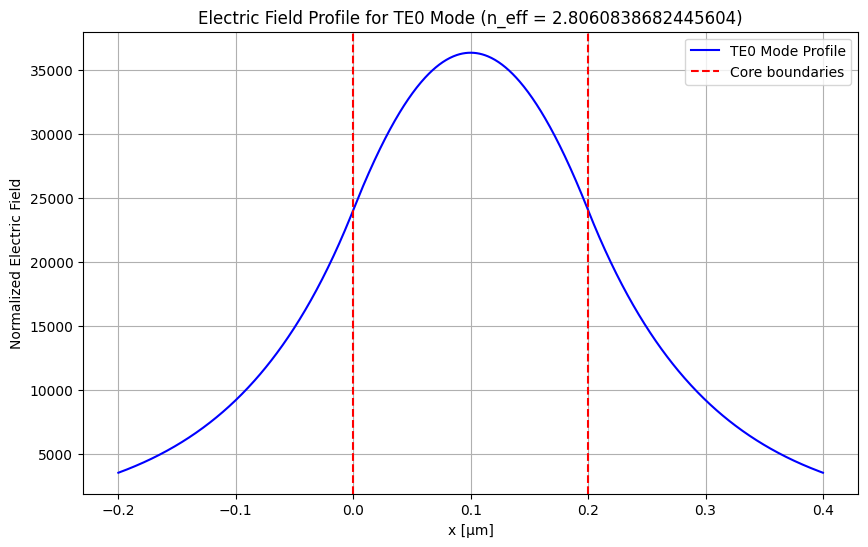

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(x * 1e6, field_profile, label="TE0 Mode Profile", color="blue")
plt.axvline(0, color='red', linestyle='--', label="Core boundaries")
plt.axvline(d * 1e6, color='red', linestyle='--')
plt.title(f"Electric Field Profile for TE0 Mode (n_eff = {beta/k0})")
plt.xlabel("x [µm]")
plt.ylabel("Normalized Electric Field")
plt.legend()
plt.grid(True)
plt.show()

In [18]:
def electric_field(x, center, h_value, p_value, d, d_coup):

    E = np.zeros_like(x)

    # Define regions based on the center
    core_region = (x >= center - d / 2) & (x <= center + d / 2)
    left_cladding = x < (center - d / 2)
    right_cladding = x > (center + d / 2)

    # Core Region
    E[core_region] = (
        np.cos(h_value * (x[core_region] - center)) / np.cos(h_value * (d / 2))
    ) * np.exp(-p_value * (d / 2))

    # Left Cladding
    E[left_cladding] = np.exp(p_value * (x[left_cladding] - center))

    # Right Cladding
    E[right_cladding] = np.exp(-p_value * (x[right_cladding] - center))

    # Calculate the integral of |E|^2 for normalization using Simpson's rule
    integral = np.trapz(np.abs(E)**2, dx = x[1] - x[0])

    # Calculate the normalization factor
    normalization_factor = 1 / integral

    # Normalize the electric field
    E *= np.sqrt(normalization_factor)

    return E

In [19]:
center_a = d / 2
center_b = (3 * d + 2 * d_coup) / 2

In [20]:
def E_a(x):
    return electric_field(x,center_a, h_value, p_value, d, d_coup)

def E_b(x):
    return electric_field(x,center_b, h_value, p_value, d, d_coup)

In [21]:
def n_a_squared(x):
    n_a_square = np.zeros_like(x)

    core_region_a = (x >= 0) & (x <= d)
    n_a_square[core_region_a] = n_core**2 - n_clad**2

    return n_a_square

def n_b_squared(x):
    n_b_square = np.zeros_like(x)

    core_region_b = (x >= d + d_coup) & (x <= 2*d + d_coup)
    n_b_square[core_region_b] = n_core**2 - n_clad**2

    return n_b_square

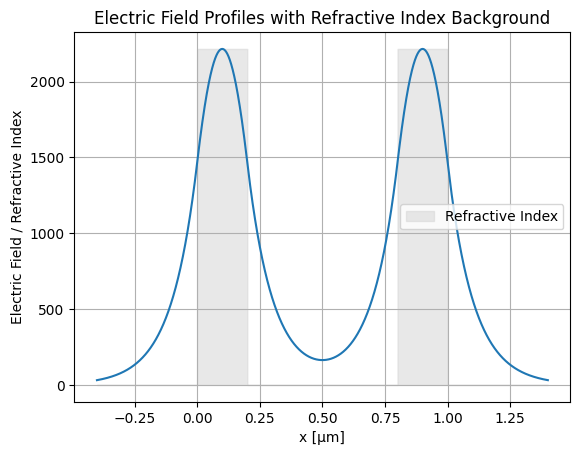

In [22]:
x = np.linspace(-2*d, 4*d + d_coup, 10000)  # Include regions outside the core
field_profile = E_a(x) + E_b(x)
n = n_a_squared(x) + n_b_squared(x)
scale_factor = max(field_profile) / max(n)
n = n * scale_factor

plt.plot(x * 1e6, field_profile)
# Plot the refractive index profile as a background
plt.fill_between(x * 1e6, n, color='lightgray', alpha=0.5, label="Refractive Index")

plt.xlabel("x [µm]")
plt.ylabel("Electric Field / Refractive Index")
plt.title("Electric Field Profiles with Refractive Index Background")
plt.legend()
plt.grid()
plt.show()


### Coupled Mode Theory – Eigen-modes

Finally, multiply by $E_a^*$ and integrate over $x$ (same for $E_b^*$) and for simplicity using the normalization condition:
$$
\int_{-\infty}^\infty |E_{a,b}|^2 dx = 1
$$

Yields the eigen-value problem for $\beta$:
$$
\begin{bmatrix}
\beta_a^2 - \beta^2 + K_a & J_a + I^* (\beta_b^2 - \beta^2) \\
J_b + I (\beta_a^2 - \beta^2) & \beta_b^2 - \beta^2 + K_b
\end{bmatrix}
\begin{pmatrix}
C_a \\
C_b
\end{pmatrix}
= 0; \quad I = \int_{-\infty}^\infty E_b^*(x)E_a(x) dx
$$

Where:
$$
J_a = k_0^2 \int_{-\infty}^\infty E_a^*(x) \Delta n_a^2(x) E_b(x) dx, \quad
K_a = k_0^2 \int_{-\infty}^\infty E_a^*(x) \Delta n_b^2(x) E_a(x) dx
$$

$$
J_b = k_0^2 \int_{-\infty}^\infty E_b^*(x) \Delta n_b^2(x) E_a(x) dx, \quad
K_b = k_0^2 \int_{-\infty}^\infty E_b^*(x) \Delta n_a^2(x) E_b(x) dx
$$

For non-trivial solutions, we need the determinant of the matrix to be zero. This leads to a quadratic equation in $\beta$ and for two eigen-modes.

### A simple and important case – two identical waveguides
$$
\beta_a = \beta_b = \beta_0; \quad J_a = J_b = J; \quad K_a = K_b = K; \quad I = I^*
$$

The eigen-value problem simplifies to:
$$
\left[ \beta_0^2 - \beta^2 + K \right]^2 = \left[ J + I (\beta_0^2 - \beta^2) \right]^2
$$

From this, we find the two eigenvalues:
$$
\beta_1^2 = \beta_0^2 + \frac{K + J}{1 + I}; \quad \beta_2^2 = \beta_0^2 + \frac{K - J}{1 - I}
$$

The corresponding eigen-modes are:
$$
E_1 = \frac{1}{\sqrt{1 + I}} (E_a + E_b), \quad
E_2 = \frac{1}{\sqrt{1 - I}} (E_a - E_b)
$$

In [23]:
def calculate_betas(x):
    dx = x[1] - x[0]
    J_a = k0 ** 2 * np.trapz(np.conj(E_a(x)) * n_a_squared(x) * E_b(x), dx=dx)
    J_b = k0 ** 2 * np.trapz(np.conj(E_b(x)) * n_b_squared(x) * E_a(x), dx=dx)
    K_a = k0 ** 2 * np.trapz(np.conj(E_a(x)) * n_b_squared(x) * E_a(x), dx=dx)
    K_b = k0 ** 2 * np.trapz(np.conj(E_b(x)) * n_a_squared(x) * E_b(x), dx=dx)
    I = np.trapz(np.conj(E_b(x)) * E_a(x), dx=dx)

    beta_plus = np.sqrt(beta ** 2 + (K_a + J_a) / (1 + I))
    beta_minus = np.sqrt(beta ** 2 + (K_a - J_a) / (1 - I))
    
    return beta_plus, beta_minus, I

In [24]:
def calculate_modes(beta_plus, beta_minus, I, x):
    E_plus = (1 / np.sqrt(1 + I)) * (E_a(x) + E_b(x))
    E_minus = (1 / np.sqrt(np.abs(1 - I))) * (E_a(x) - E_b(x))

    return E_plus, E_minus

In [25]:
beta_plus, beta_minus, I = calculate_betas(x)
# Print the results
print(f"Propagation constant for symmetric mode (beta+): {beta_plus:.4e}")
print(f"Propagation constant for antisymmetric mode (beta-): {beta_minus:.4e}")

Propagation constant for symmetric mode (beta+): 1.1381e+07
Propagation constant for antisymmetric mode (beta-): 1.1369e+07


In [26]:
E_plus, E_minus = calculate_modes(beta_plus, beta_minus, I, x)

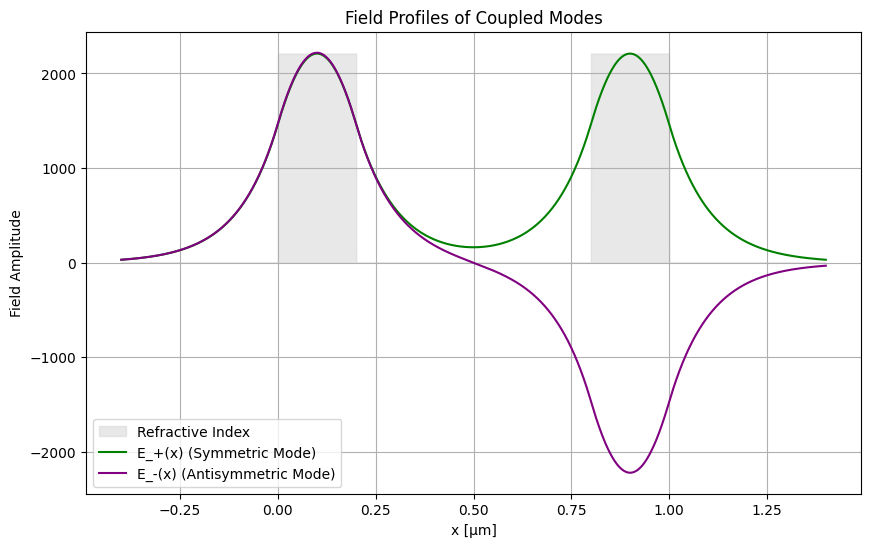

In [27]:
n = n_a_squared(x) + n_b_squared(x)
scale_factor = max(E_plus) / max(n)
n = n * scale_factor

# Plot the profiles
plt.figure(figsize=(10, 6))
plt.fill_between(x * 1e6, n, color='lightgray', alpha=0.5, label="Refractive Index")
plt.plot(x * 1e6, E_plus, label="E_+(x) (Symmetric Mode)", color="green")
plt.plot(x * 1e6, E_minus, label="E_-(x) (Antisymmetric Mode)", color="purple")
plt.title("Field Profiles of Coupled Modes")
plt.xlabel("x [µm]")
plt.ylabel("Field Amplitude")
plt.legend()
plt.grid()
plt.show()

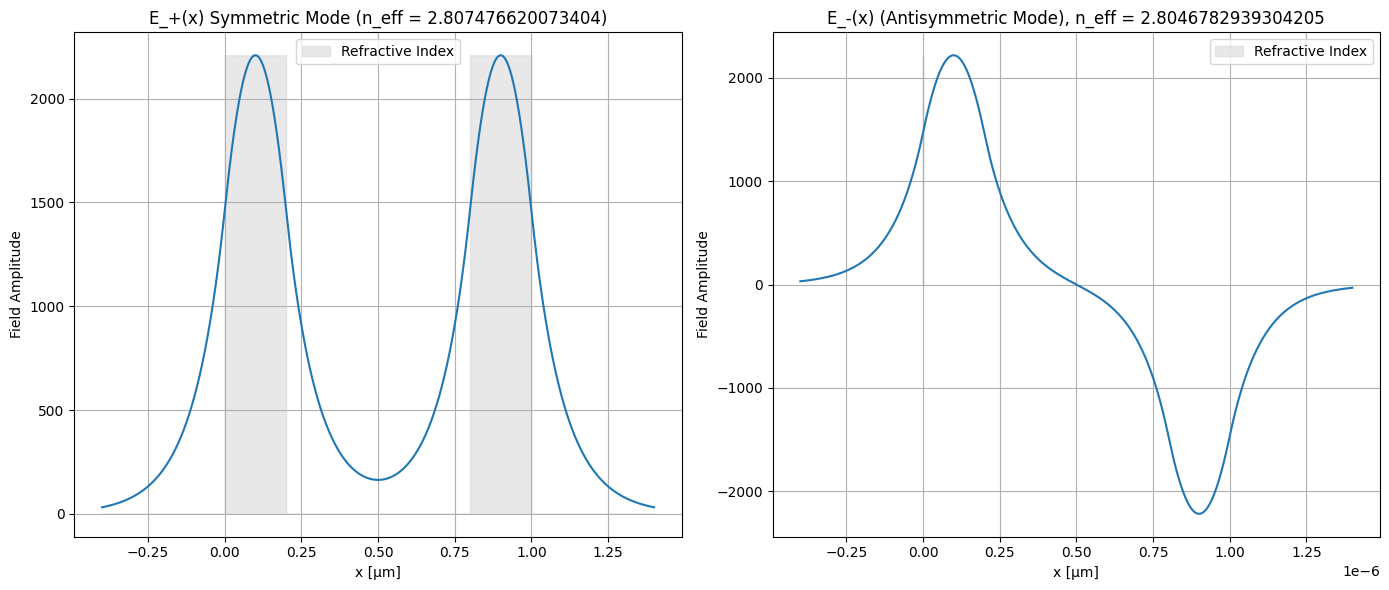

In [28]:
# Create a 1x2 grid of subplots
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot E_+ (Symmetric Mode) on the first subplot
axs[0].fill_between(x * 1e6, n, color='lightgray', alpha=0.5, label="Refractive Index")
axs[0].plot(x * 1e6, E_plus)
axs[0].set_title(f"E_+(x) Symmetric Mode (n_eff = {beta_plus/k0})")
axs[0].set_xlabel("x [µm]")
axs[0].set_ylabel("Field Amplitude")
axs[0].legend()
axs[0].grid()

# Plot E_- (Antisymmetric Mode) on the second subplot
axs[1].fill_between(x * 1e-6, n, color='lightgray', alpha=0.5, label="Refractive Index")
axs[1].plot(x, E_minus)
axs[1].set_title(f"E_-(x) (Antisymmetric Mode), n_eff = {beta_minus/k0}")
axs[1].set_xlabel("x [µm]")
axs[1].set_ylabel("Field Amplitude")
axs[1].legend()
axs[1].grid()

# Adjust layout
plt.tight_layout()
plt.show()